# Modeling – Passed and Archived Bills Only Using 'Party' Feature

## Importing Python Packages

In [1]:
# For loading, manipulating dataframe.
import pandas as pd
import sqlite3, datetime, sklearn

# Visualizations
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Text Preprocessing
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# Sampling
from imblearn.under_sampling import RandomUnderSampler 

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature Processing 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics

# Hide Warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_congress = pd.read_csv('congress_data_set.csv',index_col=0)

In [3]:
df_congress.shape

(15078, 22)

In [4]:
df_congress.head(2)

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,passed,...,Bloc,Years of Service,num_authors,delta_days,upper,mon,quarter,scope_national,majority_bloc,len_desc
0,17SBN-2235,SBN-2235,17,an act establishing the fiscal regime for the ...,5/28/19,National,"Pending Second Reading, Special Order","Drilon, Franklin M., Recto, Ralph G., Sotto II...",5/28/19,False,...,Minority,24,4,0,False,5,2,True,False,61
1,17SBN-2234,SBN-2234,17,an act authorizing the sale of certain parcels...,5/27/19,National,Approved by the President of the Philippines,"Recto, Ralph G., Sotto III, Vicente C., Escude...",6/30/19,True,...,Majority,18,3,34,False,5,2,True,True,300


In [5]:
df_congress.Party.value_counts(dropna=False)

PRP                2998
Independent        2934
PMP                2400
Nacionalista       1541
Liberal            1188
NPC                1023
PDP_Laban           728
LDP                 627
Lakas               436
Lakas-Kampi-CMD     404
Lakas-CMD           351
UNA                 281
Bagumbayan-VNP      104
Akbayan              63
Name: Party, dtype: int64

## Feature Selection

In [6]:
df_congress=df_congress[(df_congress.status=='Sent to the Archives') | (df_congress.passed==True)]
print(f"df_congress Data Points: {df_congress.shape[0]:,}")

df_congress Data Points: 529


In [7]:
df_congress.columns

Index(['bill_id', 'num', 'congress', 'long_title', 'date_filed', 'scope',
       'status', 'author', 'date_lastUpdate', 'passed',
       'Full Name Primary Author', 'Party', 'Bloc', 'Years of Service',
       'num_authors', 'delta_days', 'upper', 'mon', 'quarter',
       'scope_national', 'majority_bloc', 'len_desc'],
      dtype='object')

In [8]:
cols_of_interest = ['Party','Years of Service','num_authors','delta_days', 'mon','scope_national', 'majority_bloc', 
                    'len_desc','passed']
df_tocorr = df_congress[cols_of_interest]

In [9]:
df_tocorr.shape

(529, 9)

In [10]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [11]:
df_tocorr.shape

(529, 21)

In [12]:
df_tocorr.loc[df_tocorr.mon==1,'month']='January'
df_tocorr.loc[df_tocorr.mon==2,'month']='February'
df_tocorr.loc[df_tocorr.mon==3,'month']='March'
df_tocorr.loc[df_tocorr.mon==4,'month']='April'
df_tocorr.loc[df_tocorr.mon==5,'month']='May'
df_tocorr.loc[df_tocorr.mon==6,'month']='June'
df_tocorr.loc[df_tocorr.mon==7,'month']='July'
df_tocorr.loc[df_tocorr.mon==8,'month']='August'
df_tocorr.loc[df_tocorr.mon==9,'month']='September'
df_tocorr.loc[df_tocorr.mon==10,'month']='October'
df_tocorr.loc[df_tocorr.mon==11,'month']='November'
df_tocorr.loc[df_tocorr.mon==12,'month']='December'

In [13]:
df_tocorr.dtypes

Years of Service          int64
num_authors               int64
delta_days                int64
mon                       int64
scope_national             bool
majority_bloc              bool
len_desc                  int64
passed                     bool
Party_Bagumbayan-VNP      uint8
Party_Independent         uint8
Party_LDP                 uint8
Party_Lakas               uint8
Party_Lakas-CMD           uint8
Party_Lakas-Kampi-CMD     uint8
Party_Liberal             uint8
Party_NPC                 uint8
Party_Nacionalista        uint8
Party_PDP_Laban           uint8
Party_PMP                 uint8
Party_PRP                 uint8
Party_UNA                 uint8
month                    object
dtype: object

In [14]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [15]:
df_tocorr.shape

(529, 32)

In [16]:
df_tocorr.dtypes

Years of Service         int64
num_authors              int64
delta_days               int64
mon                      int64
scope_national            bool
majority_bloc             bool
len_desc                 int64
passed                    bool
Party_Bagumbayan-VNP     uint8
Party_Independent        uint8
Party_LDP                uint8
Party_Lakas              uint8
Party_Lakas-CMD          uint8
Party_Lakas-Kampi-CMD    uint8
Party_Liberal            uint8
Party_NPC                uint8
Party_Nacionalista       uint8
Party_PDP_Laban          uint8
Party_PMP                uint8
Party_PRP                uint8
Party_UNA                uint8
month_August             uint8
month_December           uint8
month_February           uint8
month_January            uint8
month_July               uint8
month_June               uint8
month_March              uint8
month_May                uint8
month_November           uint8
month_October            uint8
month_September          uint8
dtype: o

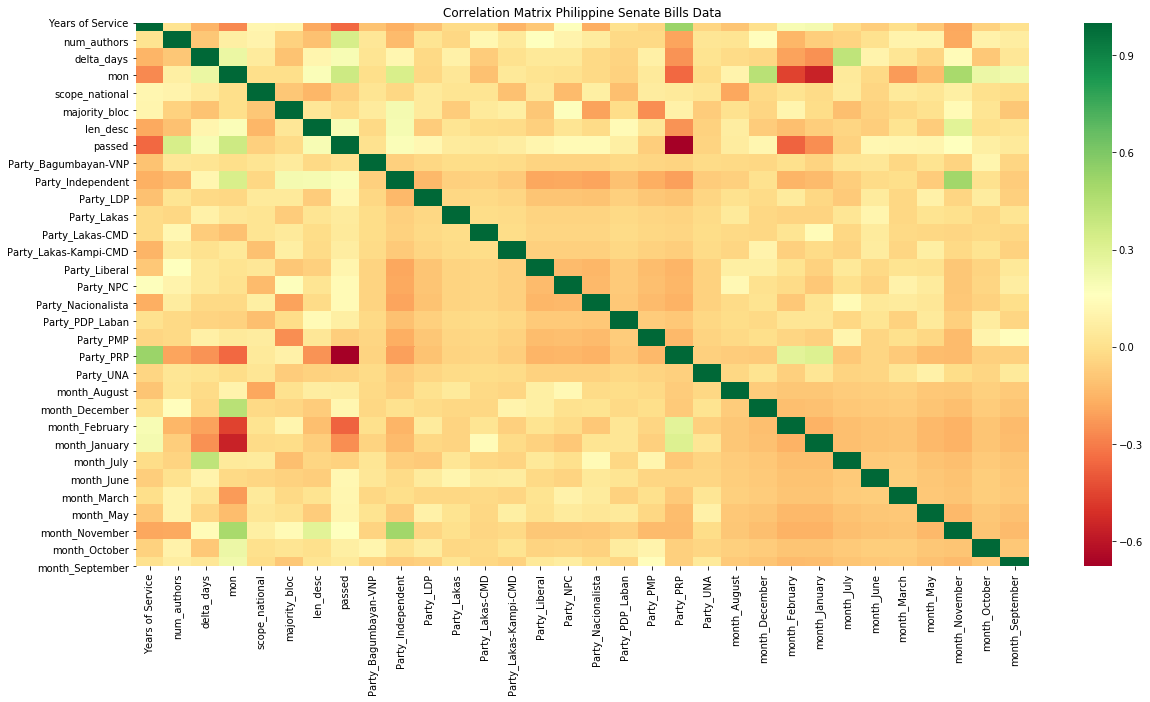

In [17]:
cor = df_tocorr.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=False,cmap="RdYlGn")
plt.title('Correlation Matrix Philippine Senate Bills Data')
plt.show()

In [18]:
df_tocorr = df_tocorr.drop(['mon','Years of Service'],axis=1)

In [19]:
pd.options.display.max_columns = None

In [20]:
cols_to_move = ['passed']
cols = [col for col in df_tocorr if col not in cols_to_move] + cols_to_move
df_tocorr = df_tocorr[cols]

In [21]:
df_tocorr.corr()

,num_authors,delta_days,scope_national,majority_bloc,len_desc,Party_Bagumbayan-VNP,Party_Independent,Party_LDP,Party_Lakas,Party_Lakas-CMD,Party_Lakas-Kampi-CMD,Party_Liberal,Party_NPC,Party_Nacionalista,Party_PDP_Laban,Party_PMP,Party_PRP,Party_UNA,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,passed
num_authors,1.000000,-0.091366,0.102895,-0.050455,-0.110259,0.031824,-0.131083,0.018623,-0.029888,0.120547,0.049086,0.164650,0.097448,0.061001,-0.027363,-0.021926,-0.196547,0.026311,0.020874,0.150235,-0.144372,-0.065062,-0.044085,0.010955,0.101357,0.097616,-0.180229,0.090299,0.066062,0.334389
delta_days,-0.091366,1.000000,0.052718,-0.105132,0.103721,0.022875,0.111786,-0.027524,0.085708,-0.073226,0.008159,0.040738,0.042659,-0.025489,-0.046150,0.082819,-0.237826,0.011759,-0.018230,-0.033249,-0.204480,-0.244509,0.411975,0.096731,0.030778,-0.038695,0.141329,-0.083019,0.033259,0.197407
scope_national,0.102895,0.052718,1.000000,-0.091173,-0.143795,0.021734,-0.032298,0.049188,0.021734,0.018333,-0.111463,0.035970,-0.130157,0.072082,-0.113374,0.062627,0.046391,0.026052,-0.188483,-0.023589,0.012721,-0.020192,0.055827,-0.035846,0.046019,0.030688,0.073896,0.003886,-0.010645,-0.057920
majority_bloc,-0.050455,-0.105132,-0.091173,1.000000,0.034083,0.056254,0.213348,0.048864,-0.070019,0.047452,0.074009,-0.092147,0.173751,-0.201430,-0.014356,-0.254394,0.087136,-0.073840,0.007431,-0.039069,0.106608,-0.011798,-0.119509,-0.049198,-0.026456,0.010816,0.134827,0.022387,-0.089662,-0.017514
len_desc,-0.110259,0.103721,-0.143795,0.034083,1.000000,-0.023666,0.202441,-0.070088,0.020605,-0.009115,-0.015947,-0.058302,0.021398,-0.015471,0.131623,0.034489,-0.239142,-0.052924,0.070071,-0.073388,-0.115918,-0.064514,-0.037230,-0.062951,0.011467,-0.068569,0.286743,0.000899,0.023701,0.194832
Party_Bagumbayan-VNP,0.031824,0.022875,0.021734,0.056254,-0.023666,1.000000,-0.059334,-0.030349,-0.013410,-0.011312,-0.017642,-0.042194,-0.041419,-0.044475,-0.024689,-0.038641,-0.047067,-0.016074,-0.027376,-0.033566,0.002936,-0.044850,0.026091,0.037108,-0.028394,0.013926,-0.045594,0.109403,-0.037414,0.008949
Party_Independent,-0.131083,0.111786,-0.032298,0.213348,0.202441,-0.059334,1.000000,-0.134285,-0.059334,-0.050051,-0.078061,-0.186692,-0.183265,-0.196786,-0.109239,-0.170972,-0.208253,-0.071122,-0.058716,0.008265,-0.147080,-0.129288,-0.067182,-0.020322,-0.004797,-0.070320,0.508811,0.006759,-0.070009,0.184177
Party_LDP,0.018623,-0.027524,0.049188,0.048864,-0.070088,-0.030349,-0.134285,1.000000,-0.030349,-0.025601,-0.039928,-0.095494,-0.093740,-0.100656,-0.055876,-0.087452,-0.106522,-0.036379,0.006899,-0.018310,0.055100,-0.032839,-0.077957,0.057041,-0.030933,0.085205,-0.035351,0.062834,-0.058326,0.119459
Party_Lakas,-0.029888,0.085708,0.021734,-0.070019,0.020605,-0.013410,-0.059334,-0.030349,1.000000,-0.011312,-0.017642,-0.042194,-0.041419,-0.044475,-0.024689,-0.038641,-0.047067,-0.016074,0.046512,-0.033566,-0.045594,-0.044850,0.026091,0.104565,-0.028394,0.013926,0.002936,-0.029384,0.019134,0.052783
Party_Lakas-CMD,0.120547,-0.073226,0.018333,0.047452,-0.009115,-0.011312,-0.050051,-0.025601,-0.011312,1.000000,-0.014882,-0.035592,-0.034939,-0.037517,-0.020826,-0.032595,-0.039703,-0.013559,-0.023093,-0.028314,0.018851,0.136197,-0.029056,0.054063,-0.023951,-0.033611,-0.038461,-0.024787,-0.031560,0.044525


In [22]:
X = df_tocorr.drop('passed',axis=1)

In [23]:
X.columns

Index(['num_authors', 'delta_days', 'scope_national', 'majority_bloc',
       'len_desc', 'Party_Bagumbayan-VNP', 'Party_Independent', 'Party_LDP',
       'Party_Lakas', 'Party_Lakas-CMD', 'Party_Lakas-Kampi-CMD',
       'Party_Liberal', 'Party_NPC', 'Party_Nacionalista', 'Party_PDP_Laban',
       'Party_PMP', 'Party_PRP', 'Party_UNA', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September'],
      dtype='object')

In [24]:
X.shape

(529, 29)

In [25]:
model_cols = X.columns.tolist()

In [26]:
y = df_tocorr['passed']

In [27]:
y.shape

(529,)

## Standardization

In [28]:
scaler = StandardScaler()

In [29]:
X = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=43)

In [31]:
print(f"Our new train set has {X_train.shape[0]} data points, {np.sum(y_train)} of which are actual positives.")

Our new train set has 396 data points, 331 of which are actual positives.


## RF

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

In [33]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
predicted = rf_model.predict(X_test)

In [35]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.96      0.85      0.90        26
        True       0.96      0.99      0.98       107

    accuracy                           0.96       133
   macro avg       0.96      0.92      0.94       133
weighted avg       0.96      0.96      0.96       133



## 18th Congress Prediction

In [82]:
df_18congress = pd.read_csv('congress18_data_set.csv',index_col=0)

In [83]:
df_18congress.head(1)

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,passed,Full Name Primary Author,Party,Bloc,Years of Service,num_authors,delta_days,mon,quarter,scope_national,majority_bloc,len_desc
0,18SBN-1153,SBN-1153,18,an act amending section 65 of republic act no....,11/6/19,National,Pending in the Committee,"Angara, Sonny",11/6/19,False,Eduardo Angara,LDP,Majority,15,1,0,11,4,True,True,123


In [38]:
df_congress=df_congress[(df_congress.congress==18)]
print(f"df_congress Data Points: {df_congress.shape[0]:,}")

df_congress Data Points: 1,149


In [39]:
df_congress=df_congress[(df_congress.Party!='CIBAC')]

In [40]:
df_congress.shape

(1098, 21)

In [41]:
df_congress.head(1)

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,passed,Full Name Primary Author,Party,Bloc,Years of Service,num_authors,delta_days,mon,quarter,scope_national,majority_bloc,len_desc
0,18SBN-1153,SBN-1153,18,an act amending section 65 of republic act no....,11/6/19,National,Pending in the Committee,"Angara, Sonny",11/6/19,False,Eduardo Angara,LDP,Majority,15,1,0,11,4,True,True,123


In [42]:
cols_of_interest = ['Party','Years of Service','num_authors','delta_days', 'mon','scope_national', 'majority_bloc', 
                    'len_desc','passed']
df_tocorr = df_congress[cols_of_interest]

In [43]:
df_tocorr.Party.value_counts(dropna=False)

Nacionalista      208
PDP_Laban         190
NPC               164
Lakas             146
Liberal           113
Independent        89
LDP                75
UNA                48
Akbayan            48
Bagumbayan-VNP     17
Name: Party, dtype: int64

In [44]:
df_tocorr.dtypes

Party               object
Years of Service     int64
num_authors          int64
delta_days           int64
mon                  int64
scope_national        bool
majority_bloc         bool
len_desc             int64
passed                bool
dtype: object

In [45]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [46]:
df_tocorr.shape

(1098, 17)

In [47]:
df_tocorr.loc[df_tocorr.mon==1,'month']='January'
df_tocorr.loc[df_tocorr.mon==2,'month']='February'
df_tocorr.loc[df_tocorr.mon==3,'month']='March'
df_tocorr.loc[df_tocorr.mon==4,'month']='April'
df_tocorr.loc[df_tocorr.mon==5,'month']='May'
df_tocorr.loc[df_tocorr.mon==6,'month']='June'
df_tocorr.loc[df_tocorr.mon==7,'month']='July'
df_tocorr.loc[df_tocorr.mon==8,'month']='August'
df_tocorr.loc[df_tocorr.mon==9,'month']='September'
df_tocorr.loc[df_tocorr.mon==10,'month']='October'
df_tocorr.loc[df_tocorr.mon==11,'month']='November'
df_tocorr.loc[df_tocorr.mon==12,'month']='December'

In [48]:
df_tocorr.head(1)

,Years of Service,num_authors,delta_days,mon,scope_national,majority_bloc,len_desc,passed,Party_Bagumbayan-VNP,Party_Independent,Party_LDP,Party_Lakas,Party_Liberal,Party_NPC,Party_Nacionalista,Party_PDP_Laban,Party_UNA,month
0,15,1,0,11,True,True,123,False,0,0,1,0,0,0,0,0,0,November


In [49]:
df_tocorr.shape

(1098, 18)

In [50]:
df_tocorr.dtypes

Years of Service         int64
num_authors              int64
delta_days               int64
mon                      int64
scope_national            bool
majority_bloc             bool
len_desc                 int64
passed                    bool
Party_Bagumbayan-VNP     uint8
Party_Independent        uint8
Party_LDP                uint8
Party_Lakas              uint8
Party_Liberal            uint8
Party_NPC                uint8
Party_Nacionalista       uint8
Party_PDP_Laban          uint8
Party_UNA                uint8
month                   object
dtype: object

In [51]:
columnsToEncode=df_tocorr.select_dtypes(include=[object]).columns
df_tocorr = pd.get_dummies(df_tocorr, columns=columnsToEncode, drop_first=True)

In [52]:
df_tocorr.shape

(1098, 21)

In [53]:
df_tocorr.head(2)

,Years of Service,num_authors,delta_days,mon,scope_national,majority_bloc,len_desc,passed,Party_Bagumbayan-VNP,Party_Independent,Party_LDP,Party_Lakas,Party_Liberal,Party_NPC,Party_Nacionalista,Party_PDP_Laban,Party_UNA,month_July,month_November,month_October,month_September
0,15,1,0,11,True,True,123,False,0,0,1,0,0,0,0,0,0,0,1,0,0
1,15,1,0,11,True,True,234,False,0,0,0,0,0,1,0,0,0,0,1,0,0


In [54]:
df_tocorr.dtypes

Years of Service        int64
num_authors             int64
delta_days              int64
mon                     int64
scope_national           bool
majority_bloc            bool
len_desc                int64
passed                   bool
Party_Bagumbayan-VNP    uint8
Party_Independent       uint8
Party_LDP               uint8
Party_Lakas             uint8
Party_Liberal           uint8
Party_NPC               uint8
Party_Nacionalista      uint8
Party_PDP_Laban         uint8
Party_UNA               uint8
month_July              uint8
month_November          uint8
month_October           uint8
month_September         uint8
dtype: object

In [55]:
df_tocorr.columns

Index(['Years of Service', 'num_authors', 'delta_days', 'mon',
       'scope_national', 'majority_bloc', 'len_desc', 'passed',
       'Party_Bagumbayan-VNP', 'Party_Independent', 'Party_LDP', 'Party_Lakas',
       'Party_Liberal', 'Party_NPC', 'Party_Nacionalista', 'Party_PDP_Laban',
       'Party_UNA', 'month_July', 'month_November', 'month_October',
       'month_September'],
      dtype='object')

In [56]:
df_tocorr = df_tocorr.drop(['mon','Years of Service'],axis=1)

In [57]:
df_tocorr.columns

Index(['num_authors', 'delta_days', 'scope_national', 'majority_bloc',
       'len_desc', 'passed', 'Party_Bagumbayan-VNP', 'Party_Independent',
       'Party_LDP', 'Party_Lakas', 'Party_Liberal', 'Party_NPC',
       'Party_Nacionalista', 'Party_PDP_Laban', 'Party_UNA', 'month_July',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

In [58]:
X = df_tocorr.copy()

In [59]:
input18_cols = X.columns.tolist()

In [60]:
missing_cols = [col for col in model_cols if col not in input18_cols]
missing_cols

['Party_Lakas-CMD',
 'Party_Lakas-Kampi-CMD',
 'Party_PMP',
 'Party_PRP',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_June',
 'month_March',
 'month_May']

In [63]:
for col in missing_cols:
    X[col]=0

In [67]:
X = X.drop(['passed'],axis=1)

In [68]:
X = scaler.transform(X)

In [69]:
predicted_18 = rf_model.predict(X)

In [72]:
len(predicted_18)

1098

In [76]:
df_congress['prediction']=predicted_18

In [78]:
df_congress.head()

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,passed,Full Name Primary Author,Party,Bloc,Years of Service,num_authors,delta_days,mon,quarter,scope_national,majority_bloc,len_desc,prediction
0,18SBN-1153,SBN-1153,18,an act amending section 65 of republic act no....,11/6/19,National,Pending in the Committee,"Angara, Sonny",11/6/19,False,Eduardo Angara,LDP,Majority,15,1,0,11,4,True,True,123,True
1,18SBN-1152,SBN-1152,18,an act providing insurance coverage to profess...,11/6/19,National,Pending in the Committee,"Lapid, Manuel ""Lito"" M.",11/6/19,False,Lito Lapid,NPC,Majority,15,1,0,11,4,True,True,234,True
2,18SBN-1151,SBN-1151,18,an act providing for free freight services in ...,11/6/19,National,Pending in the Committee,"Lapid, Manuel ""Lito"" M.",11/6/19,False,Lito Lapid,NPC,Majority,15,1,0,11,4,True,True,107,True
3,18SBN-1150,SBN-1150,18,an act incorporating a system of special educa...,11/5/19,National,Pending in the Committee,"Binay, Maria Lourdes Nancy S.",11/6/19,False,Nancy Binay,UNA,Majority,6,1,1,11,4,True,True,361,True
4,18SBN-1149,SBN-1149,18,an act creating the philippine arbitration com...,11/5/19,National,Pending in the Committee,"Binay, Maria Lourdes Nancy S.",11/6/19,False,Nancy Binay,UNA,Majority,6,1,1,11,4,True,True,153,True


In [84]:
df_congress.passed.sum()

0

In [79]:
bills_pass_18 = df_congress[df_congress.prediction==True]
bills_rej_18 = df_congress[df_congress.prediction==False]

In [86]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', -1)

In [87]:
bills_pass_18[['num','long_title','status','author']]

,num,long_title,status,author
0,SBN-1153,"an act amending section 65 of republic act no. 11260, otherwise known as the general appropriations act of fiscal year 2019",Pending in the Committee,"Angara, Sonny"
1,SBN-1152,an act providing insurance coverage to professional filipino athletes who are competing in any international professional sports competition or in other equally prestigious international championship games and providing funds therefor,Pending in the Committee,"Lapid, Manuel ""Lito"" M."
2,SBN-1151,an act providing for free freight services in the transportation of relief goods to calamity-stricken areas,Pending in the Committee,"Lapid, Manuel ""Lito"" M."
3,SBN-1150,"an act incorporating a system of special education in all public and private elementary and secondary schools nationwide for children and youth with special needs, institutionalizing the bureau of special education, creating the implementing machinery thereof, providing guidelines for government financial assistance and other incentives and for other purposes",Pending in the Committee,"Binay, Maria Lourdes Nancy S."
4,SBN-1149,"an act creating the philippine arbitration commission and institutionalizing compulsory arbitration for specific areas of dispute, and for other purposes",Pending in the Committee,"Binay, Maria Lourdes Nancy S."
7,SBN-1146,an act providing for medical parole to qualified persons deprived of liberty and setting rules on the grant thereof,Pending in the Committee,"De Lima, Leila M."
8,SBN-1145,an act institutionalizing human rights as a separate and specialized subject in both basic and higher education,Pending in the Committee,"De Lima, Leila M."
9,SBN-1144,"an act redefining the dominant majority and minority parties during national and local elections, amending for the purpose, republic act no. 7166, otherwise known as, 'an act for synchronized national and local elections and for electoral reforms, authorizing appropriations therefor, and for other purposes",Pending in the Committee,"De Lima, Leila M."
11,SBN-1142,an act regulating short-term residential rental and establishing a registry for such purpose,Pending in the Committee,"Lapid, Manuel ""Lito"" M."
12,SBN-1141,an act institutionalizing a nationwide language revitalization program and providing funds therefor,Pending in the Committee,"Lapid, Manuel ""Lito"" M."


In [90]:
bills_pass_18[['num','long_title','status','author']].to_csv('bills_pass_18.csv')

In [89]:
bills_rej_18[['num','long_title','status','author']]

,num,long_title,status,author
5,SBN-1148,"an act amending section 58 of republic act no. 8551, otherwise known as the 'philippine national police reform and reorganization act of 1998', appropriating funds therefor and for other purposes",Pending in the Committee,"De Lima, Leila M."
10,SBN-1143,"an act institutionalizing the philippine navy forward operating bases, appropriating funds for the establishment thereof, and for other purposes",Pending in the Committee,"Tolentino, Francis ""Tol"" N."
14,SBN-1139,"an act creating the department of disaster resilience, defining its powers and functions, and appropriating funds therefor",Pending in the Committee,"Zubiri, Juan Miguel ""Migz"" F."
16,SBN-1137,"an act creating the department of water resources management, defining its powers and functions, and appropriating funds therefor, and for other purposes",Pending in the Committee,"Dela Rosa, Ronald ""Bato"""
26,SBN-1127,"an act establishing the coconut trust fund, providing for its management and utilization, reconstituting the philippine coconut authority, and for other purposes",Pending in the Committee,"Marcos, Imee R."
27,SBN-1126,"an act expanding the philhealth outpatient coverage on dialysis and renal replacement therapy, and for other purposes",Pending in the Committee,"Marcos, Imee R."
28,SBN-1125,"an act creating the national resiliency and disaster management authority, prescribing its powers and functions, appropriating funds therefor, and for other purposes",Pending in the Committee,"Marcos, Imee R."
29,SBN-1124,"an act amending sections 443, 454, and 463 of republic act no. 7160 otherwise known as the ‘local government code of 1991",Pending in the Committee,"Binay, Maria Lourdes Nancy S."
30,SBN-1123,an act providing for a five (5)-day special emergency leave for all workers in the public and private sector directly affected by natural calamities or disasters,Pending in the Committee,"De Lima, Leila M."
32,SBN-1121,"an act providing for the mandatory inclusion of anti-obesity education program and exercise including play and traditional games, in the pre-school, elementary and high school curricula, both in public and private schools and educational institutions and for other purposes",Pending in the Committee,"Revilla Jr., Ramon Bong"


In [91]:
bills_rej_18[['num','long_title','status','author']].to_csv('bills_rej_18.csv')